In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *

In [2]:
torch.cuda.is_available()

False

In [3]:
G_21 = xr.open_dataset("../dataset/G_21_subset_imputed.nc")
G_21 = G_21.to_array().values.squeeze(0)
G_21.shape

(3565, 102484)

In [12]:
real_data_index = True
n = 1000
p = 10000
p_causal = 100
batch_size = n
if real_data_index:
    np.random.seed(seed = None)
    p_max = G_21.shape[1]
    n_max = G_21.shape[0]
    SNP_index = np.random.choice(p_max,size = p, replace = False)
    subject_index =  np.random.choice(n_max,size = n, replace = False)
    G_21_sub = G_21[np.ix_(subject_index, SNP_index)]
    print(G_21_sub.shape)
    freq_snp = G_21_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    G_21_sub = (G_21_sub-2*freq_snp)/sd_snp
    Xs = [G_21_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None

(1000, 10000)


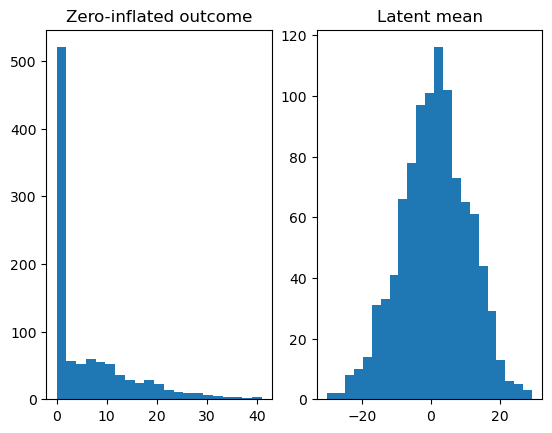

------------------------------------
genetic variance is 97.70228812116385
total variance is195.4045762423277
heritability is 0.5
------------------------------------


In [13]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.5
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)


In [14]:
class Sim_Dataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]
sim_data = Sim_Dataset(X.double(),y_star.double())
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)

In [18]:
model = linear_slab_spike(p = p, init_pi_local = 0.2, init_pi_global = 0.1, init_beta_var = 2, init_noise_var = 0.1,
                         gumbel_softmax_temp = 0.1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=0.1, init_a3= 0.1, init_a4 = 0.1,
                          q1 = 1.1, q2 = 1.1, init_q3 = 1.1, init_q4 = 1.1, n_E = 10, prior_sparsity = True
                         ).double()
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local, 'lr': 0.5},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.log_q3},
     {'params': model.log_q4},
     {'params': model.bias},
     {'params': model.logit_pi_global, 'lr': 0.5},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.05)

In [19]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
t = 100 #number of moving averages
patience = 50# patience
p_cur = 0 
min_avg_loss = float('inf')
losses = []
for i in range(10000):
    for j, (X_batch, y_batch) in enumerate(sim_data_loader):
        loss = -model.ELBO(X_batch,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if i % 1000 == 0:
        lr_scheduler.step()
        print(f'At iteration {i}, the loss is {loss.item()}')
    if i > t:
        cur_avg_loss = np.mean(losses[-t:-1])
        if cur_avg_loss < min_avg_loss:
            min_avg_loss = cur_avg_loss
            p_cur = 0
            best_model = copy.deepcopy(model)
        else:
            p_cur += 1
    if p_cur > patience:
        break

At iteration 0, the loss is 304350.80587581784
At iteration 1000, the loss is 9535.496485346357
At iteration 2000, the loss is 8642.951422842176
At iteration 3000, the loss is 8349.681033075016
At iteration 4000, the loss is 8240.892009612531
At iteration 5000, the loss is 8191.963658738454


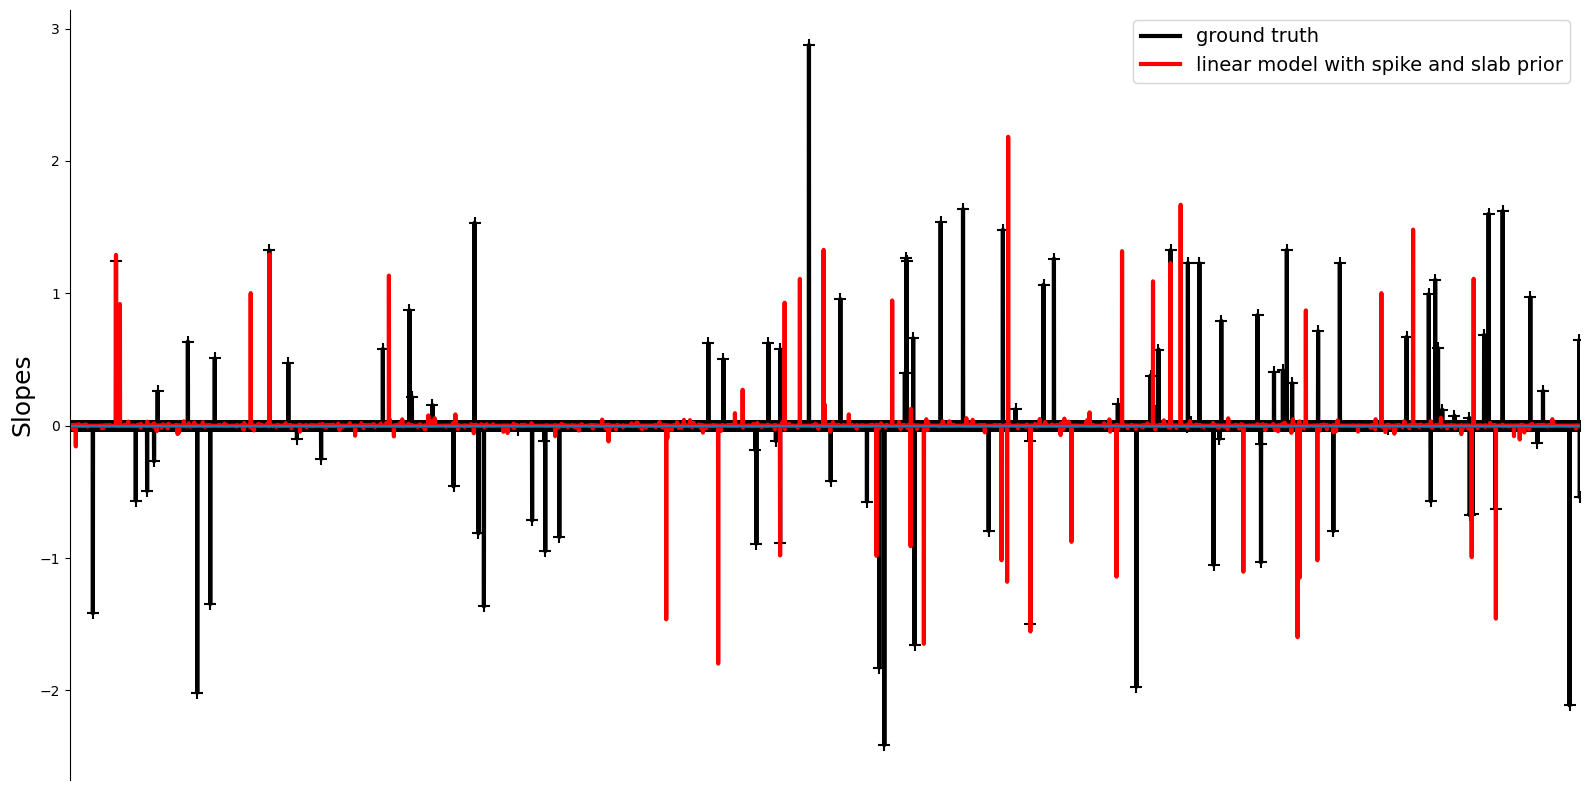

{'mean_h_est': 0.47748780267802726,
 'h_est_upper': 0.6377679635552594,
 'h_est_lower': 0.3040266065190211,
 'mean_var_genetic': 118.65579689257484,
 'noise_var': 137.45131008370097,
 'global_pi': 0.01225503122845634,
 'global_pi_upper': 0.0191603874078577,
 'global_pi_lower': 0.00702654792997916}

In [20]:
best_model.inference(X = X.double(),  num_samples = 1000, plot = True, true_beta = true_beta)

In [ ]:
p_causal/p

In [ ]:
torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))
torch.min(model.beta_mu)
torch.max(model.beta_mu)
torch.exp(model.beta_log_var)
torch.mean(torch.exp(model.beta_log_var))

tensor(0.0016)

In [11]:
c = torch.exp(best_model.log_c).detach().numpy()
d = torch.exp(best_model.log_d).detach().numpy()
# c = 10
# d = 10
print(c)
print(d)
posterior = np.random.beta(c,d,size = (5000,))
np.median(posterior)
print(np.quantile(posterior, q = 0.025))
print(np.quantile(posterior, q = 0.975))
plt.hist(posterior)
plt.show()

tensor(2.1269e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(3.6996e-08, dtype=torch.float64, grad_fn=<MinBackward1>)
